<a href="https://colab.research.google.com/github/rrankawat/anomaly-detection/blob/main/AD_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Parameters
data_dir = "/content/drive/My Drive/MVTecAD/hazelnut"
batch_size = 16
latent_dim = 128
lr = 0.0001
epochs = 10

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [8]:
def load_mvtec_data(data_dir, batch_size):
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_mvtec_data(data_dir, batch_size)

In [9]:
# Attention UNet-based Autoencoder
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

In [10]:
class AttentionUNet(nn.Module):
    def __init__(self):
        super(AttentionUNet, self).__init__()
        self.encoder1 = ConvBlock(3, 32)
        self.encoder2 = ConvBlock(32, 64)
        self.encoder3 = ConvBlock(64, 128)
        self.encoder4 = ConvBlock(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(256, 512)

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(64, 32)

        self.final_conv = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.final_conv(d1))

In [11]:
# Loss and Optimizer
model = AttentionUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [14]:
# Training Loop
def train_and_validate(model, train_loader, val_loader, device, epochs):
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            reconstructed = model(images)
            loss = loss_fn(reconstructed, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}")

train_and_validate(model, train_loader, val_loader, device, epochs)

Epoch 1/10, Train Loss: 0.0982
Epoch 2/10, Train Loss: 0.0368
Epoch 3/10, Train Loss: 0.0166
Epoch 4/10, Train Loss: 0.0076
Epoch 5/10, Train Loss: 0.0058
Epoch 6/10, Train Loss: 0.0043
Epoch 7/10, Train Loss: 0.0025
Epoch 8/10, Train Loss: 0.0013
Epoch 9/10, Train Loss: 0.0010
Epoch 10/10, Train Loss: 0.0008


In [15]:
# Feature-based Anomaly Detection using VGG
vgg = models.vgg16(pretrained=True).features[:10].to(device)
vgg.eval()

def compute_feature_loss(original, reconstructed):
    with torch.no_grad():
        original_features = vgg(original)
        reconstructed_features = vgg(reconstructed)
    return torch.mean((original_features - reconstructed_features) ** 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 176MB/s]


In [16]:
# Anomaly Scoring
def anomaly_score(model, data_loader, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = model(images)
            loss = compute_feature_loss(images, reconstructed)
            scores.append(loss.item())
    return np.array(scores)

scores = anomaly_score(model, val_loader, device)
threshold = np.mean(scores) + 3 * np.std(scores)

In [17]:
# Visualize reconstructions with anomaly detection
def visualize_reconstructions(model, data_loader, device, threshold):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)
    reconstructed = model(images)  # Get reconstructed images

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        # Compute anomaly score **before** converting to NumPy
        score = compute_feature_loss(images[i:i+1], reconstructed[i:i+1]).item()
        label = "Defective" if score > threshold else "Good"

        # Convert for visualization
        img_np = images[i].cpu().numpy()
        recon_np = reconstructed[i].cpu().detach().numpy()

        # Plot original
        axes[0, i].imshow(np.transpose(img_np, (1, 2, 0)))
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        # Plot reconstructed with label
        axes[1, i].imshow(np.transpose(recon_np, (1, 2, 0)))
        axes[1, i].axis("off")
        axes[1, i].set_title(label)

    plt.show()

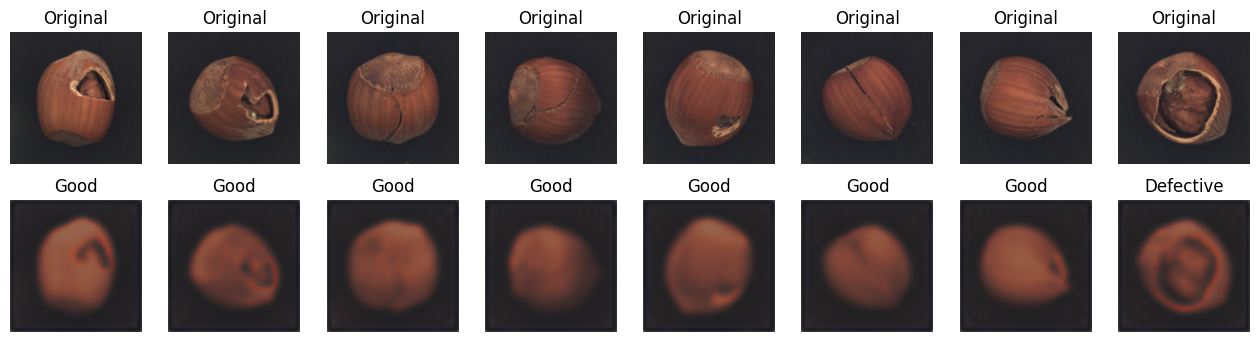

In [18]:
visualize_reconstructions(model, val_loader, device, threshold)